# Counterfactual instances on MNIST

Given a test instance $X$, this method can generate counterfactual instances $X^\prime$ given a desired counterfactual class $t$ which can either be a class specified upfront or any other class that is different from the predicted class of $X$.

The loss function for finding counterfactuals is the following: 

$$L(X^\prime\vert X) = (f_t(X^\prime) - p_t)^2 + \lambda L_1(X^\prime, X).$$

The first loss guides the search towards instances $X^\prime$ for which the predicted class probability $f_t(X^\prime)$ is close to a pre-specified target class probability $p_t$ (typically $p_t=1$). The second loss terms ensures that the counterfactuals are close in the feature space to the original test instance.

In this notebook we illustrate the usage of the basic counterfactual algorithm on the MNIST dataset.

In [1]:
import keras
from keras import backend as K
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from keras.models import Model, load_model
from keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from time import time
from alibi.explainers import CounterFactual

Using TensorFlow backend.


## Load and prepare MNIST data

x_train shape: (60000, 28, 28) y_train shape: (60000,)


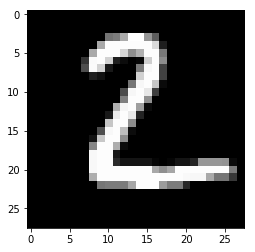

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[1]);

Prepare data: scale, reshape and categorize

In [3]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [4]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

## Define and train CNN model

In [5]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)
    
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return cnn

In [6]:
cnn = cnn_model()
cnn.summary()
cnn.fit(x_train, y_train, batch_size=64, epochs=3, verbose=1)
cnn.save('mnist_cnn.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxP

Evaluate the model on test set

In [7]:
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.986


## Generate counterfactuals

Original instance:

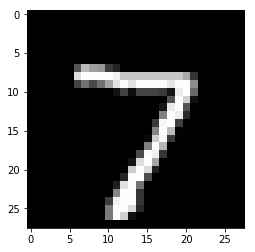

In [8]:
X = x_test[0].reshape((1,) + x_test[0].shape)
plt.imshow(X.reshape(28, 28));

Counterfactual parameters:

In [9]:
shape = (1,) + x_train.shape[1:]
target_proba = 1.0
tol = 0.01 # want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than 7 will do
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (x_train.min(),x_train.max())

Run counterfactual:

In [10]:
# set random seed
np.random.seed(1)
tf.set_random_seed(1)

sess = K.get_session()

# initialize explainer
cf = CounterFactual(sess, cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Explanation took 5.552 sec


Results:

Counterfactual prediction: 9 with probability 0.9936296343803406


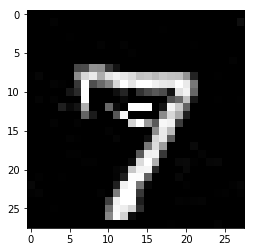

In [11]:
pred_class = explanation['cf']['class']
proba = explanation['cf']['proba'][0][pred_class]

print(f'Counterfactual prediction: {pred_class} with probability {proba}')
plt.imshow(explanation['cf']['X'].reshape(28, 28));

The counterfactual starting from a 7 moves towards the closest class as determined by the model and the data: a 9. The evolution of the counterfactual during the iterations over $\lambda$ can be seen below (note that all of the following examples satisfy the counterfactual condition):

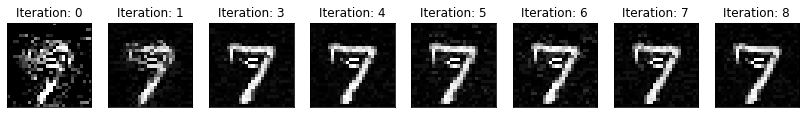

In [12]:
n_cfs = np.array([len(explanation['all'][iter_cf]) for iter_cf in range(max_lam_steps)])
examples = {}
for ix, n in enumerate(n_cfs):
    if n>0:
        examples[ix] = {'ix': ix, 'lambda': explanation['all'][ix][0]['lambda'],
                       'X': explanation['all'][ix][0]['X']}
columns = len(examples) + 1
rows = 1

fig = plt.figure(figsize=(16,6))

for i, key in enumerate(examples.keys()):
    ax = plt.subplot(rows, columns, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(examples[key]['X'].reshape(28,28))
    plt.title(f'Iteration: {key}')

Typically, the first few iterations find counterfactuals that are out of distribution, while the later iterations make the counterfactual more sparse and interpretable.

Let's now try to steer the counterfactual to a specific class:

In [13]:
target_class = 1

cf = CounterFactual(sess, cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

explanation = start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 4.737 sec


Results:

Counterfactual prediction: 1 with probability 0.9970157146453857


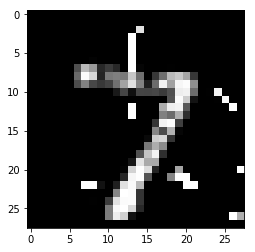

In [14]:
pred_class = explanation['cf']['class']
proba = explanation['cf']['proba'][0][pred_class]

print(f'Counterfactual prediction: {pred_class} with probability {proba}')
plt.imshow(explanation['cf']['X'].reshape(28, 28));

As you can see, by specifying a class, the search process can't go towards the closest class to the test instance (in this case a 9 as we saw previously), so the resulting counterfactual might be less interpretable. But in fact, because the MNIST dataset contains a lot of diagonally slanted 1's, the returned counterfactual is not that surprising.

Clean up:

In [15]:
os.remove('mnist_cnn.h5')